In [2]:
%matplotlib inline
import sys
import os
sys.path.append('/home/kihyun/data/projects/kihyun/Editing-benchmark/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import json
from collections import defaultdict
from tqdm import tqdm
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [3]:
dataDir='/home/kihyun/data/dataset/COCO2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
json_dir = '/home/kihyun/data/projects/kihyun/Editing-benchmark/edit_task_v2.json'
catnms = [] # 해당 object가 모두 있는 이미지만 선택 및 프롬프트 저장
Annotation = True # Annotation mask를 이미지에 표시할지 여부
save_dir = './img_above_certain_size_bbox' # 프롬프트 저장 위치
save_img = False

In [4]:
cat_dir = '_'.join(catnms) # 프롬프트 저장 위치
save_path = os.path.join(save_dir, cat_dir)
if not os.path.exists(save_path):
        os.makedirs(save_path)

In [5]:
# initialize COCO api for instance annotations
# annotation file을 읽어서 COCO object를 생성
coco=COCO(annFile)

loading annotations into memory...


Done (t=0.63s)
creating index...
index created!


In [19]:
def img_idx_list(coco):
    imgIds = coco.getImgIds()
    print("Number of images in the dataset: ", len(imgIds))
    return len(imgIds), imgIds

def img_show(coco, imgId, mask=False, catnms=None, save_path=save_path, save = save_img):
    img = coco.loadImgs(imgId)[0]
    I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
    #I = io.imread(img['coco_url'])
    plt.axis('off')
    plt.imshow(I)
    if mask:
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        coco.showAnns(anns)
    if save:
        save_name = f'{imgId}.jpg'
        img_path = os.path.join(save_path, save_name)
        plt.savefig(img_path)
    plt.close()
    
def multi_img_show(coco, imgId_ls, mask=False, catnms=None):
    # valid_imgIds = []
    category_count = defaultdict(int)

    count = 0
    for i, imgId in enumerate(tqdm(imgId_ls, desc="Downloading images")):
        image_summary = calculate_image_summary(coco, [imgId])
        if image_summary:
            img_show(coco, imgId, mask)
            # valid_imgIds.append(imgId)
            count += 1
            for category in image_summary.keys():
                category_count[category] += image_summary[category][0]
    
    # with open('./img_above_certain_size_bbox_list.txt', 'w') as f:
    #     for valid_imgId in valid_imgIds:
    #         f.write(f'{valid_imgId}\n')
    
    return count, category_count
        
def save_edit_prompts(json_dir, save_path=save_path):
    # read json file
    with open(json_dir, 'r') as f:
        json_data = json.load(f)
    # save edit prompts in prompt_save_dir
   
    file_name = f'edit_prompts_{catnms}.txt'
    txt_path = os.path.join(save_path, file_name)
    ff = open(txt_path, 'w')
    for cat in catnms:
        for edit_task in json_data[cat].keys():
            for subtask in json_data[cat][edit_task]['to']:
                ff.write(f'{cat}, {edit_task}, {subtask}\n')
                ff.write('---------------------\n')
    ff.close()

def calculate_image_summary(coco, imgId_ls):
    category_info = defaultdict(lambda: [0, 0.0])  # {category_name: [count, total_area]}

    for imgId in imgId_ls:
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            category_name = coco.loadCats(ann['category_id'])[0]['name']
            bbox = ann['bbox']  # [x, y, width, height]
            width, height = bbox[2], bbox[3]
            area = width * height
            # if area < 1000:
            #     # process_single_image(coco, imgId, json_dir)
            #     return None
            
            category_info[category_name][0] += 1
            
            # if category_info[category_name][0] >= 2:
            #     # process_single_image(coco, imgId, json_dir)
            #     return None
            category_info[category_name].append(area)
    
    image_summary = {cat: info for cat, info in category_info.items()}
    return image_summary

def calculate_single_image_summary(coco, imgId_ls):
    category_info = defaultdict(lambda: [0, 0.0])  # {category_name: [count, total_area]}

    for imgId in imgId_ls:
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        for ann in anns:
            category_name = coco.loadCats(ann['category_id'])[0]['name']
            bbox = ann['bbox']  # [x, y, width, height]
            width, height = bbox[2], bbox[3]
            area = width * height
            category_info[category_name][0] += 1
            category_info[category_name].append(area)

    image_summary = {cat: info for cat, info in category_info.items()}
    return image_summary

def plot_category_count(category_count):
    categories = list(category_count.keys())
    counts = list(category_count.values())
    total_count = sum(counts)

    # 개수를 기준으로 내림차순 정렬
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_categories = [categories[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(sorted_categories, sorted_counts, color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Category Percentage in Original Images')
    plt.xticks(rotation=90)

    # x축 간격 조정
    plt.gca().set_xticks(plt.gca().get_xticks()[::2])

    # 각 바 위에 개수 표시
    for bar, count in zip(bars, sorted_counts):
        yval = bar.get_height()
        percent = (count / total_count) * 100
        plt.text(bar.get_x() + bar.get_width() / 2, yval, \
                 f'{int(count)}, {percent:.1f}%', ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

def show_cat_imgs_n_prompt(coco, json_dir):
    n, imgId_ls = img_idx_list(coco)
    count, category_count = multi_img_show(coco, imgId_ls, mask=Annotation)
    # save_edit_prompts(catnms, json_dir)   # 일단 이미지만 체크
    plot_category_count(category_count)
    return count, category_count

def process_single_image(coco, imgId, json_dir):
    img_show(coco, imgId, mask=Annotation, save_path='./small_bbox_or_multi_cats/', save=False)
    image_summary = calculate_single_image_summary(coco, imgId)
    return image_summary

{'bottle': [1, 0.0, 2251.6725],
 'dining table': [1, 0.0, 64736.6188],
 'person': [2, 0.0, 30374.4042, 2285.6232],
 'knife': [1, 0.0, 642.5928],
 'bowl': [4, 0.0, 2781.3396000000002, 3141.6909999999993, 445.8939, 282.5452],
 'oven': [2, 0.0, 18942.127200000003, 18940.812800000003],
 'cup': [2, 0.0, 850.085, 1154.3334],
 'broccoli': [3, 0.0, 60.0446, 267.8728, 42.502399999999994],
 'spoon': [1, 0.0, 163.8756],
 'carrot': [1, 0.0, 38.1024],
 'sink': [1, 0.0, 3490.7061]}

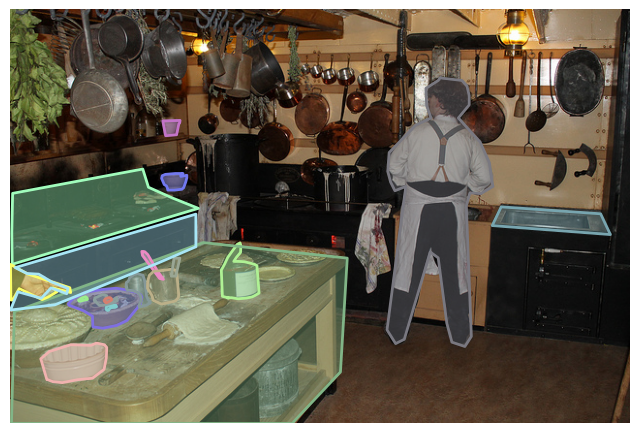

In [14]:
process_single_image(coco, [397133], json_dir)

Number of images in the dataset:  5000


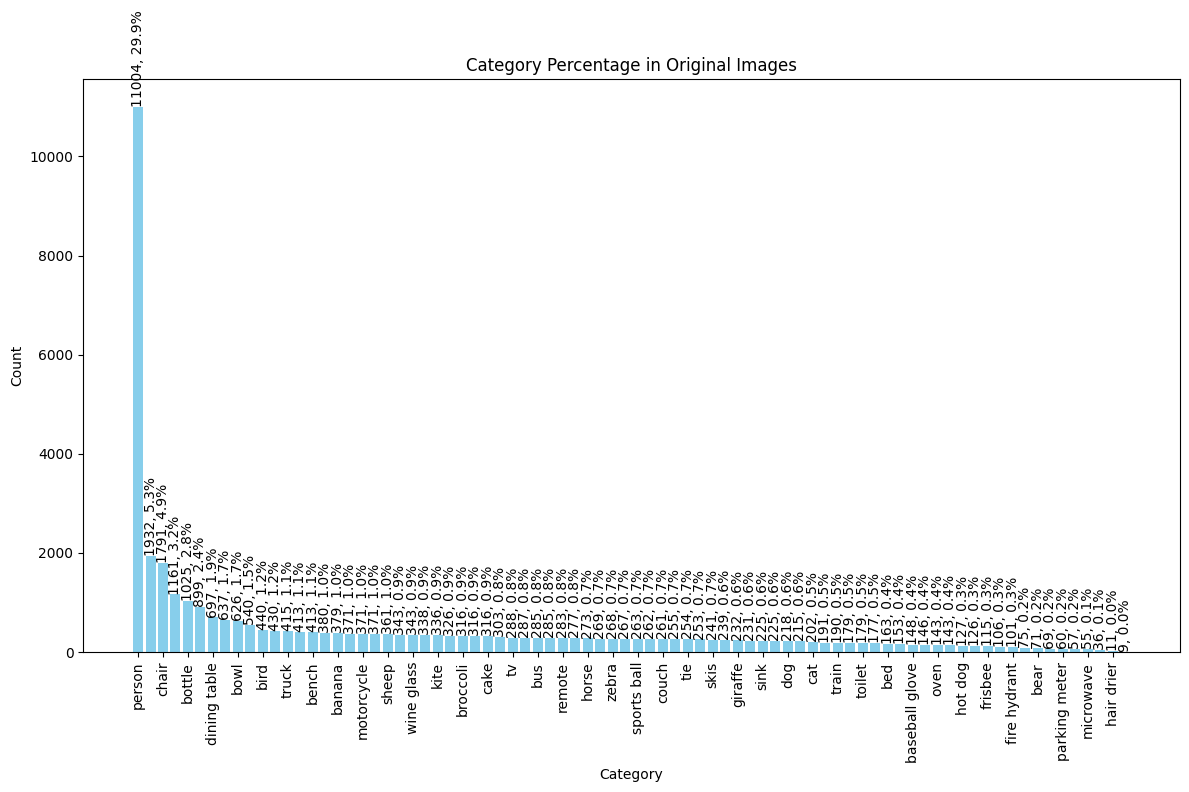

Valid images: 4952 
Number of each category: defaultdict(<class 'int'>, {'bottle': 1025, 'dining table': 697, 'person': 11004, 'knife': 326, 'bowl': 626, 'oven': 143, 'cup': 899, 'broccoli': 316, 'spoon': 253, 'carrot': 371, 'sink': 225, 'potted plant': 343, 'chair': 1791, 'refrigerator': 126, 'banana': 379, 'orange': 287, 'umbrella': 413, 'handbag': 540, 'traffic light': 637, 'bicycle': 316, 'skateboard': 179, 'car': 1932, 'truck': 415, 'toilet': 179, 'motorcycle': 371, 'bird': 440, 'keyboard': 153, 'book': 1161, 'tv': 288, 'vase': 277, 'couch': 261, 'airplane': 143, 'suitcase': 303, 'giraffe': 232, 'cow': 380, 'boat': 430, 'bench': 413, 'sheep': 361, 'bus': 285, 'backpack': 371, 'train': 190, 'stop sign': 75, 'dog': 218, 'cat': 202, 'laptop': 231, 'tie': 254, 'elephant': 255, 'clock': 267, 'frisbee': 115, 'bear': 71, 'zebra': 268, 'horse': 273, 'skis': 241, 'sports ball': 263, 'baseball glove': 148, 'donut': 338, 'sandwich': 177, 'cake': 316, 'surfboard': 269, 'bed': 163, 'pizza': 28

In [20]:
count, category_count = show_cat_imgs_n_prompt(coco, json_dir)
print("Valid images:", count, "\nNumber of each category:", category_count)